In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
output_file = "dataset.csv"
combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [9]:
combined_df.to_csv(output_file, index=False)
print(f"Updated combined dataset saved to {output_file}")

Updated combined dataset saved to dataset.csv


In [11]:
print(combined_df.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')


In [13]:
combined_df.dropna(inplace=True)

In [15]:
combined_df.to_csv(output_file, index=False)

In [17]:
print(f"Cleaned and combined dataset saved to {output_file}")

Cleaned and combined dataset saved to dataset.csv


In [21]:
def preprocess_for_arima(df):
    required_columns = ['Outlet_Establishment_Year', 'Item_Outlet_Sales']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise KeyError(f"The dataset is missing required columns: {missing_columns}")
    df = df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum().reset_index()
    df = df.sort_values(by='Outlet_Establishment_Year')
    df.set_index('Outlet_Establishment_Year', inplace=True)
    
    return df
try:
    processed_data = preprocess_for_arima(combined_df)
    print("Processed Data:")
    print(processed_data.head())
except Exception as e:
    print(f"Error during preprocessing: {e}")

Processed Data:
                           Item_Outlet_Sales
Outlet_Establishment_Year                   
1987                            2.142664e+06
1997                            2.118395e+06
1999                            2.183970e+06
2004                            2.268123e+06
2009                            1.851823e+06


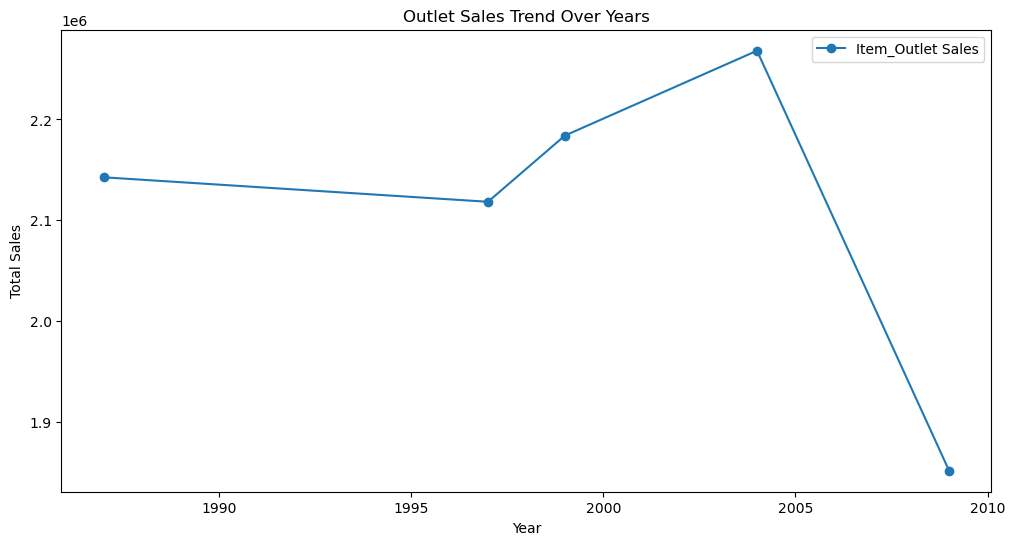

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(processed_data.index, processed_data['Item_Outlet_Sales'], marker='o', label="Item_Outlet Sales")
plt.title("Outlet Sales Trend Over Years")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

In [25]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] > 0.05:
        print("The series is non-stationary. Differencing is required.")
    else:
        print("The series is stationary. No differencing is required.")
        
check_stationarity(processed_data['Item_Outlet_Sales'])

ADF Statistic: -2.4601345765497262
p-value: 0.12547769093281902
The series is non-stationary. Differencing is required.


In [27]:
processed_data.index = pd.to_datetime(processed_data.index, format='%Y')

In [29]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(processed_data['Item_Outlet_Sales'])
print("p-value:", result[1])

p-value: 0.12547769093281902


In [33]:
processed_data['Differenced_Sales'] = processed_data['Item_Outlet_Sales'].diff().dropna()

In [35]:
processed_data.index = pd.to_datetime(processed_data.index, format='%Y')

In [37]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(processed_data['Item_Outlet_Sales'])
print("p-value:", result[1])

p-value: 0.12547769093281902


In [39]:
processed_data = processed_data.resample('M').sum()

In [41]:
print(processed_data.isnull().sum())

Item_Outlet_Sales    0
Differenced_Sales    0
dtype: int64


In [43]:
processed_data['Differenced_Sales'].fillna(0, inplace=True)

Number of observations in differenced data: 265


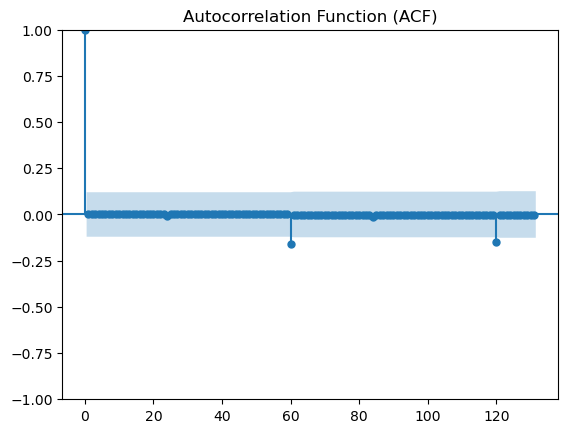

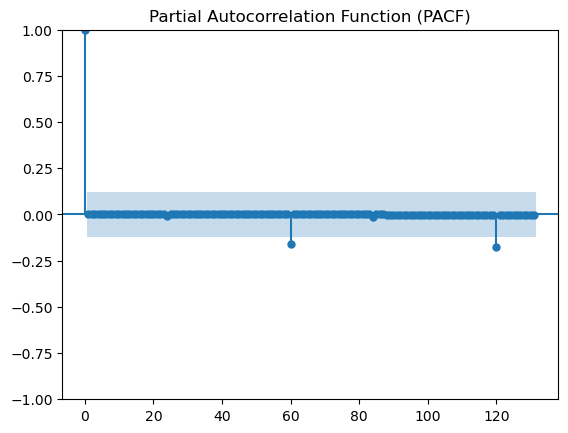

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check the number of observations in the differenced data
num_observations = len(processed_data['Differenced_Sales'].dropna())
print(f"Number of observations in differenced data: {num_observations}")

# Calculate valid maximum lags
max_lags = max(1, num_observations // 2 - 1)  # Ensure it's strictly less than 50%

# Plot ACF
plot_acf(processed_data['Differenced_Sales'].dropna(), lags=max_lags)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plot_pacf(processed_data['Differenced_Sales'].dropna(), lags=max_lags)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [49]:
model = ARIMA(processed_data['Item_Outlet_Sales'], order=(1, 1, 1))  # Example parameters: p=1, d=1, q=1
fitted_model = model.fit()

In [51]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:      Item_Outlet_Sales   No. Observations:                  265
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3682.216
Date:                Fri, 13 Dec 2024   AIC                           7370.432
Time:                        00:22:45   BIC                           7381.160
Sample:                    01-31-1987   HQIC                          7374.743
                         - 01-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0450      0.065      0.696      0.486      -0.082       0.172
ma.L1         -0.9982      0.022    -46.249      0.000      -1.040      -0.956
sigma2       8.26e+10   3.01e-13   2.74e+23      0.0

In [53]:
forecast_steps = 5  # Example: Predict 5 future years
forecast = fitted_model.forecast(steps=forecast_steps)

In [55]:
print("Forecasted Sales for Future Years:")
print(forecast)

Forecasted Sales for Future Years:
2009-02-28    121973.733072
2009-03-31     44072.237558
2009-04-30     40564.045419
2009-05-31     40406.058567
2009-06-30     40398.943835
Freq: M, Name: predicted_mean, dtype: float64


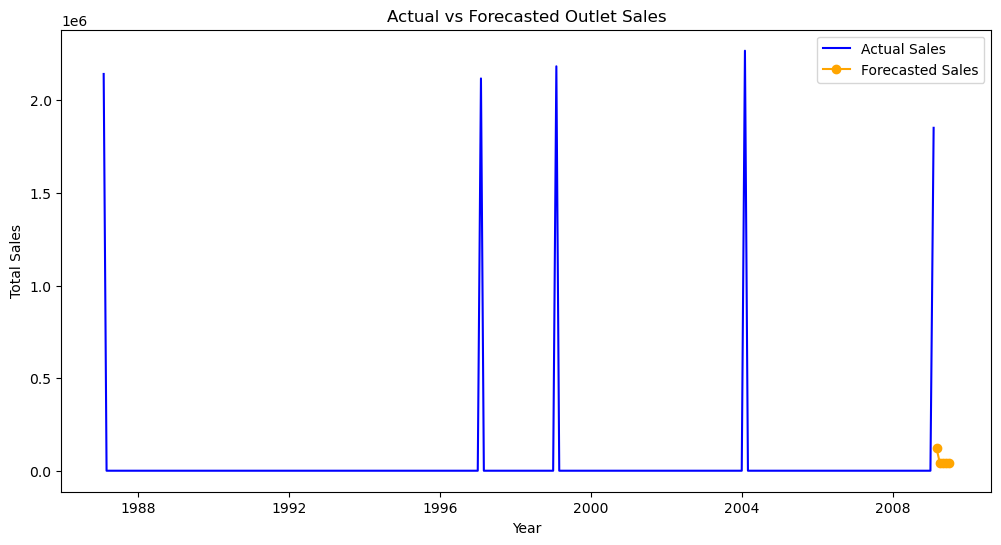

In [57]:
# Assuming processed_data has a DatetimeIndex
plt.figure(figsize=(12, 6))
plt.plot(processed_data.index, processed_data['Item_Outlet_Sales'], label="Actual Sales", color="blue")

# Generate future dates using the frequency of the index
future_years = pd.date_range(
    start=processed_data.index[-1] + processed_data.index.freq,
    periods=forecast_steps,
    freq=processed_data.index.freq
)

# Plot the forecast
plt.plot(future_years, forecast, label="Forecasted Sales", color="orange", marker='o')
plt.title("Actual vs Forecasted Outlet Sales")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

In [59]:
if len(processed_data['Differenced_Sales'].dropna()) > 1:
    residuals = fitted_model.resid
    mae = mean_absolute_error(processed_data['Item_Outlet_Sales'][-len(residuals):], residuals + processed_data['Item_Outlet_Sales'][-len(residuals):])
    rmse = np.sqrt(mean_squared_error(processed_data['Item_Outlet_Sales'][-len(residuals):], residuals + processed_data['Item_Outlet_Sales'][-len(residuals):]))
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 92918.30900154685
Root Mean Squared Error (RMSE): 307262.97426485113
